# Building a methylation-informed regulatory network
Daniel C Morgan<sup>1</sup>

<sup>1</sup>Channing Division of Network Medicine, Harvard Medical School, Boston, MA.

## Introduction

Inexpensive, high quality methylation platforms (illumina 450k/850k arrays) have shifted the prospect of integrating such omics into more traditional resources for the inference of gene regulatory networks (GRN). The recent literature has expanded in every direction to take advantage of this new, ubiquitous data source, and as such a wide range of approaches have been proposed. Recent publications range from potential use cases where it makes the most sense to account for DNA methylation in regulatory framework to methodological approaches for doing just that without regard for the research question. This book chapter is organized based upon this continuum, starting with use cases most appropriate for taking advantage of DNA methylation information towards more recent approaches of methodologies and frameworks for appropriately and accurately doing so. Lastly, we shall work through a modern approach for both, namely a meGRN framework and use case example, to see the utility methylation can lend to an investigation.

## Loading libraries

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import scipy
import pandas as pd
from sklearn import metrics
import multiprocessing as mp
from functools import partial
# from pybedtools import BedTool ##super limited capabilities

In [ ]:
os.chdir('../netZooPy')
!pip install -e ./

In [ ]:
import netZooPy
from netZooPy.panda import Panda
from netZooPy.lioness import Lioness
# from netZooPy.milipede import Milipede
os.chdir('../MIMB/')

In [ ]:
##install bedtools
# https://bedtools.readthedocs.io/en/latest/content/installation.html

## Motivation

The matter involves finding regions of known TF binding which also have methylation events proximal to these locations. For this, one can rely on WGBS chromosome location or array data which illumina provides cg names for, which map to similar locations.


## Pipeline:
  0. FIMO scan & open-access data (via [previous example](http://netbooks.networkmedicine.org/user/42270c34-aea7-4c9d-b95a-4c4ad2c3a715/notebooks/netZooPy/Building_a_regulation_prior_network.ipynb))
  1. setting up bedtools
  2. Intersections & slop
    1. Integrating into bipartite format
    1. Integrating into other GRN framework
      1. Smaller GRN models (TF-gene subsets) could just merge with methyl-motif and reduce their estimates where overlap / downweight (GRN estimate x 1- avg meth ratio)
  3. Benchmarking against ChIP-seq

## Skip to relevant sections:
* [__0. PWM-based pre-Motif__](#0.-PWM-based-pre-Motif)
* [__I. Data Processing__](#I.-Data-Processing)
   * [A. Gather Data](#A.-Gathering-data)
   * [B. Intersection Operations](#B.-Intersection-Operations-&-Organization)
   * [C. Export bipartite, sparse format](#C.-Export-bipartite,-sparse-format)
* [__II. Accuracy Scoring__](#II.-Accuracy-Scoring)
   - [A. Score intersection](#A.-Plot-distributions-and-score-against-ChIP)
   - [B. Score after running thru PANDA](#B.-Score-and-compare-PANDA)
   - [C. Score Slop intersection](#C.-Score-and-compare-Slop)
   - [D. Score Slop after running thru PANDA](#D.-Score-and-compare-Slop-run-thru-PANDA)
* [__III. Summary__](#III.-Summary)
* [__IV. full scale, partial methyl Motif__](#IV.-full-scale,-partial-methyl-Motif)

# 0. PWM-based pre-Motif

#### these are essentially PWM TF files formated into bed files

### download prerequisite data:
* PWMs per TF
* hg38 fasta file

In [117]:
# !wget http://cisbp.ccbr.utoronto.ca/tmp/Homo_sapiens_2021_06_24_4:21_pm.zip
# !wget http://humantfs.ccbr.utoronto.ca/download/v_1.01/PWMs.zip
# !wget https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz

--2021-06-24 16:11:12--  http://cisbp.ccbr.utoronto.ca/tmp/Homo_sapiens_2021_06_24_4:21_pm.zip
Resolving cisbp.ccbr.utoronto.ca (cisbp.ccbr.utoronto.ca)... 142.150.52.218
Connecting to cisbp.ccbr.utoronto.ca (cisbp.ccbr.utoronto.ca)|142.150.52.218|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271709153 (259M) [application/zip]
Saving to: ‘Homo_sapiens_2021_06_24_4:21_pm.zip’

Homo_sapiens_2021_0 100%[===================>] 259.12M  2.42MB/s    in 1m 42s  

2021-06-24 16:12:54 (2.54 MB/s) - ‘Homo_sapiens_2021_06_24_4:21_pm.zip’ saved [271709153/271709153]



### read in and process

In [52]:
import zipfile
zip = zipfile.ZipFile('PWMs.zip')
nn = zip.namelist()
file = pd.read_csv(zip.open(nn[1]),sep='\t')

### install MEME

In [ ]:
%%bash
wget https://meme-suite.org/meme/meme-software/5.3.3/meme-5.3.3.tar.gz
tar zxf meme-5.3.3.tar.gz
cd meme-5.3.3
./configure --prefix=$HOME/meme --with-url=http://meme-suite.org --enable-build-libxml2 --enable-build-libxslt
make
make test
make install

### convert ccbr pwm into meme format & run FIMO

In [ ]:
%%bash
mdir="./PWMs/"
tmp="./tmp/"
out="./hg38_Motif/"
rm -r -i -f $tmp
rm -r -i -f $out
mkdir $tmp
mkdir $out

motifs=$(ls $mdir)
for mfile in $motifs
do
eval "./meme-5.3.3/scripts/matrix2meme <" $mdir$mfile "> " $tmp$mfile".meme"
eval "./meme-5.3.3/src/fimo --thresh 0.0001 --text "$tmp$mfile".meme hg38.fa > "$out$mfile
done

### parse FIMO output to bed files
#### may need to update which columns to pull when file formats update

In [ ]:
%%bash
mapdir="./hg38_Motif/"
beddir="./hg38_bed/"
mkdir $beddir

maps=$(eval "ls "$mapdir"*.txt | cut -d / -f3 | cut -d . -f1,2")

for mfile in $maps
do
echo $mfile
eval "sort -u "$mapdir$mfile".txt -k3,5 > temp.txt" 
eval "awk '{if(\$3 ~ /chr/){print \$3\"\t\"\$4\"\t\"\$5\"\t\"\$3\":\"\$4\"-\"\$5\"\t\"\$7\"\t\"\$6\"\t\"\$8 > \""$beddir$mfile".bed\"}}' tmp.txt"
rm -I tmp.txt
done


# I. Data Processing

## A. Gathering data

#### scale orders : TF > TSS annotation > WGBS >> ChIP

In [ ]:
%%bash
## GM12878 WGBS
wget https://www.encodeproject.org/files/ENCFF005TID/@@download/ENCFF005TID.bed.gz
gunzip ENCFF005TID.bed.gz

# ## PPI
wget https://granddb.s3.amazonaws.com/gpuPANDA/ppi2015_freezeCellLine.txt

## remap ChIP (filter to A549)
wget http://remap.univ-amu.fr/storage/remap2020/hg38/MACS2/remap2020_nr_macs2_hg38_v1_0.bed.gz
gunzip remap2020_nr_macs2_hg38_v1_0.bed.gz
grep GM12878 remap2020_nr_macs2_hg38_v1_0.bed |cut -f1,2,3,4 > | cut -d: -f1 gm12878_chip.txt

# read conversion file
unzip hg38_Tss_coordinates.csv.zip


In [ ]:
# geneCorr = pd.read_csv('hg38_Tss_coordinates.csv',sep='\t')
# geneCorr[['chrom','txStart','txEnd','name2']].to_csv('hg38_gene_coord.txt',sep='\t',header=False,index=False)

## B. Intersection Operations & Organization

#### build all previous motif info (with chr-start-end info) into megamotif file

save all output from previous motif step as concatenated "mega motif" file, rather than deleting it as tmp, so you can now operate over it all

In [ ]:
%%bash
motifdir="./hg38_bed/"  ## chr start stop pwm per gene name/
motiffiles=$(ls $motifdir/*)
for tf in $motiffiles #
do
    awk '{print($3,"\t",$4,"\t",$5,"\t",$7,"\t",$2)}' $tf |tail -n +2>>mega_motif.txt
done

cut -f1 mega_motif.txt -d -
tr -d ' ' < mega_motif0.txt > mega_motif00.txt
awk  '$3!=""' mega_motif1.txt > mega_motif01.txt

### format gene info

In [ ]:
%%bash
cut -f3,7,8,13 hg38_Tss_coordinates.csv | tail -n +2 > hg38_tss_coord.txt
../../../../udd/rekrg/Tools/bedtools2/bin/bedtools intersect -wa -wb -a mega_motif01.txt -b hg38_tss_coord.txt > mega_motif_refseq.txt
# ../../../../udd/rekrg/Tools/bedtools2/bin/bedtools intersect -wao -a ../../../../udd/redmo/data/MotifPipeline/ENCODE/wgbsin/GM12878both.txt -b ../../../../udd/redmo/data/MotifPipeline/remap/GM12878_spRE2020.txt > GM12878_BS_Ch.txt
## also process with steps 2 cells below
../../../../udd/rekrg/Tools/bedtools2/bin/bedtools slop -i mega_motif_refseq.txt -g ../rekrg/Tools/bedtools2/genomes/human.hg38.genome -r 100 -l 100  > slop_mega_BS_Ch0.txt

# ../../../../udd/rekrg/Tools/bedtools2/bin/bedtools intersect -wao -a mega_motif_refseq.txt -b GM12878_BS_Ch01.txt > mega_BS_Ch0.txt

../../../../udd/rekrg/Tools/bedtools2/bin/bedtools intersect -wao -a slop_mega_motif_refseq.txt -b GM12878_BS_Ch01.txt > slop_mega_BS_Ch0.txt
# cut -f1,2,3,4,5,9,13,14,15 mega_BS_Ch0.txt |


In [2]:
import time
time.strftime("%Y%m%d")

'20210519'

#### build mega_motif using larger window

this relaxes the precision of overlap between the methylation and the motif region, thus allowing for more distant regulation by methylation. This has been shown to be stable up to +/-250bp, and for the example here we set it to +/- below

In [ ]:
!bedtools slop  -i mega_motif01.txt -g ../rekrg/Tools/bedtools2/genomes/human.hg38.genome -r 100 -l 100 > megaSlop100.txt

### intersect WGBS with ChIP (does not depend on motif window) & format

We can save a step in the loop processing of these files by first intersecting these huge "backbone" files

In [ ]:
%%bash
bedtools intersect -wao -a ENCFF005TID.bed -b gm12878_chip.txt > GM12878_BS_Ch.txt
sed -i.bak 's/\t\t/\t/' GM12878_BS_Ch.txt
cut -f1,2,3,4,5,9 GM12878_BS_Ch.txt > GM12878_BS_Ch0.txt
cat GM12878_BS_Ch0.txt | tr "." 0 >GM12878_BS_Ch01.txt


### intersect motif with WGBS-ChIP (with or without buffer)

For matters of computational efficiency, break down files read in into chunks, depending on their overall size, and run in parallel

In [ ]:
!wc -l Motif_BS_Ch.txt ## 226877058

In [ ]:
!bedtools intersect -wa -wb -a mega_motif01.txt -b GM12878_BS_Ch01.txt > Motif_BS_Ch.txt

def maxHit(i,chunk_size):
    print(i)
    data=pd.read_csv('Motif_BS_Ch.txt',sep='\t',header=None,nrows=chunk_size,skiprows=chunk_size*i)
    data1=data.groupby([0,1,2,10]).max()
    data1[3]=data1[3].round(4)
    data1[[3,4,8,9]].to_csv('Motif_BS_Chmax.txt',sep='\t',index=True,header=False,mode='a')

chunk_size=100000
# for i in range(np.round(3505594261/chunk_size).astype('int')): ## will NOT be the same length, despite the want
xx=range(np.round(226877058/chunk_size).astype('int'))

pool = mp.Pool(20)
res  = pool.map(partial(maxHit,chunk_size=chunk_size),xx)



In [ ]:
!wc -l slop100_Motif_BS_Ch.txt ## 3505594261

In [ ]:
!bedtools intersect -wa -wb -a megaSlop100.txt -b GM12878_BS_Ch01.txt > slop100_Motif_BS_Ch.txt

def maxHit(i,chunk_size):
    print(i)
    data=pd.read_csv('slop100_Motif_BS_Ch.txt',sep='\t',header=None,nrows=chunk_size,skiprows=chunk_size*i)
    data1=data.groupby([0,1,2,10]).max()
    data1[3]=data1[3].round(4)
    data1[[3,4,8,9]].to_csv('slop100_Motif_BS_Chmax.txt',sep='\t',index=True,header=False,mode='a')


chunk_size=1000000
# for i in range(np.round(3505594261/chunk_size).astype('int')): ## will NOT be the same length, despite the want
xx=range(np.round(3505594261/chunk_size).astype('int'))

pool = mp.Pool(20)
res  = pool.map(partial(maxHit,chunk_size=chunk_size),xx)



### intersect in gene information & reduce to max and unique locations

Here we get to the naming of the genes, added to the TFs and ChIP information we already have. This process further restrict our search space

In [ ]:
%%bash
bedtools intersect -wa -wb -a Motif_BS_Chmax.txt -b hg38_tss_coord.txt > Motif_BS_Chmax_refseq.txt
awk '{print($4,"\t",$5,"\t",$6,"\t",$7,"\t",$8,"\t",$12)}' Motif_BS_Chmax_refseq.txt |uniq >>uniq_Motif_BS_Chmax_refseq.txt

In [1]:
%%bash
bedtools intersect -wa -wb -a slop100_Motif_BS_Ch.txt -b hg38_tss_coord.txt > slop100_Motif_BS_Ch_refseq.txt
awk '{print($4,"\t",$5,"\t",$6,"\t",$7,"\t",$8,"\t",$12)}' slop100_Motif_BS_Ch_refseq.txt |uniq >>uniq_slop100_Motif_BS_Ch_refseq.txt

/bin/sh: ../../../../udd/rekrg/Tools/bedtools2/bin/bedtools: No such file or directory


## C. Export bipartite, sparse format

In [ ]:
%%bash
tr -d '(' < mean_chip.txt > mega_slop100_motif00.txt
tr -d ')' < mega_slop100_motif00.txt > mega_slop100_motif01.txt
cut -f2,3,4 mega_slop100_motif01.txt | tail -n +2 > mean_chip_uniqMotif_BS_Chmax_refseq_slop100.txt

tr -d '(' < min_chip.txt > mega_slop100_motif00.txt
tr -d ')' < mega_slop100_motif00.txt > mega_slop100_motif01.txt
cut -f2,3,4 mega_slop100_motif01.txt | tail -n +2 > min_chip_uniqMotif_BS_Chmax_refseq_slop100.txt

tr -d '(' < max_chip.txt > mega_slop100_motif00.txt
tr -d ')' < mega_slop100_motif00.txt > mega_slop100_motif01.txt
cut -f2,3,4 mega_slop100_motif01.txt | tail -n +2 > max_chip_uniqMotif_BS_Chmax_refseq_slop100.txt

# II. Accuracy Scoring

## A. Plot distributions and score against ChIP

   each of these sections contains 6 AUROC scores, one for PWM and one for bisulfite for each of mean, max and min variants to handle multiple hits per motif region

In [19]:
data=pd.read_csv('uniqMotif_BS_Chmax_refseq.zip',sep='\t',names=['ChIPTF','pwm','TF','wgbs','W1','gene'])

three estimates are taken to reduce multiply characterized links (occurences of TF-gene pairs), as one might expect they are: mean, max and min, presented below

<ipython-input-20-23e538faf59c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.ChIPTF[data.ChIPTF!='0 ']=1


['mean pwm motif=0.6082067034901157', 'mean wgbs motif=0.6393551915608513']


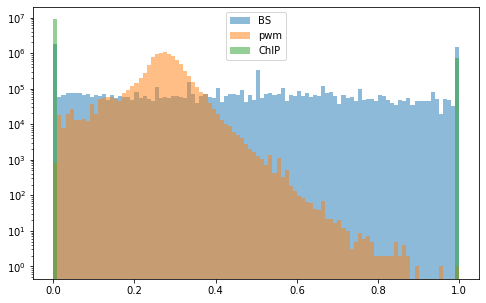

In [20]:
table=[]
data.ChIPTF[data.ChIPTF!='0 ']=1
data['ChIPTF']=pd.to_numeric(data['ChIPTF'])
ss=data.groupby(['TF','gene']).agg({'pwm':'mean',"W1":'mean',"ChIPTF":'max'})
ss.pwm=(ss.pwm-ss.pwm.min())/(ss.pwm.max()-ss.pwm.min())
fpr, tpr, thresholds = metrics.roc_curve(ss.ChIPTF, 1-(ss.W1/100))
roc_auc=metrics.auc(fpr, tpr)

fpr2, tpr2, thresholds2 = metrics.roc_curve(ss.ChIPTF, ss.pwm)
roc_auc2=metrics.auc(fpr2, tpr2)

print(['mean pwm motif='+str(roc_auc2),'mean wgbs motif='+str(roc_auc)])

plt.figure(figsize=(8, 5))

ss.W1=np.round(1-(ss.W1/100),decimals=4)
ss.pwm=np.round(ss.pwm,decimals=4)

tmp=plt.hist(ss.W1,bins=100,label='BS',alpha=.5,log=True)
tmp=plt.hist(ss.pwm,bins=100,label='pwm',alpha=.5,log=True)
tmp=plt.hist(ss.ChIPTF,bins=100,label='ChIP',alpha=.5,log=True)

plt.legend(loc="best")
table.append(["0_mean",roc_auc2,roc_auc])

In [194]:
ss=ss.reset_index() ## save for PANDA runs
ss.TF=ss.TF.str.replace('(', '')
ss.TF=ss.TF.str.replace(')', '')
ss.TF=ss.TF.str.replace(' ', '')
ss.gene=ss.gene.str.replace(' ', '')
ss[['TF','gene','pwm']].to_csv('mean_pwm_uniqMotif_BS_Chmax_refseq.txt',header=False,index=False,sep='\t')
ss[['TF','gene','W1']].to_csv('mean_wgbs_uniqMotif_BS_Chmax_refseq.txt',header=False,index=False,sep='\t')

['max wgbs motif=0.722342834898407', 'max wgbs motif=0.4138085647374004']


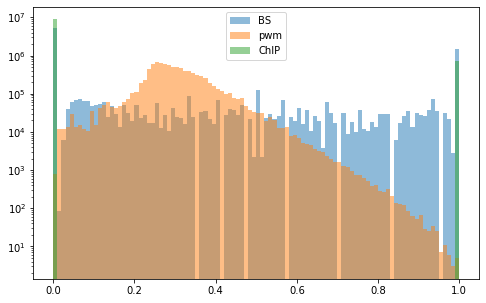

In [21]:
ss=data.groupby(['TF','gene']).agg({'pwm':'max',"W1":'max',"ChIPTF":'max'})
ss.pwm=(ss.pwm-ss.pwm.min())/(ss.pwm.max()-ss.pwm.min())
fpr, tpr, thresholds = metrics.roc_curve(ss.ChIPTF, 1-(ss.W1/100))
roc_auc=metrics.auc(fpr, tpr)

fpr2, tpr2, thresholds2 = metrics.roc_curve(ss.ChIPTF, ss.pwm)
roc_auc2=metrics.auc(fpr2, tpr2)

print(['max pwm motif='+str(roc_auc2),'max wgbs motif='+str(roc_auc)])

plt.figure(figsize=(8, 5))

ss.W1=np.round(1-(ss.W1/100),decimals=4)
ss.pwm=np.round(ss.pwm,decimals=4)

tmp=plt.hist(ss.W1,bins=100,label='BS',alpha=.5,log=True)
tmp=plt.hist(ss.pwm,bins=100,label='pwm',alpha=.5,log=True)
tmp=plt.hist(ss.ChIPTF,bins=100,label='ChIP',alpha=.5,log=True)

plt.legend(loc="best")
table.append(["0_max",roc_auc2,roc_auc])

In [8]:
ss=ss.reset_index()
ss.TF=ss.TF.str.replace('(', '')
ss.TF=ss.TF.str.replace(')', '')
ss.TF=ss.TF.str.replace(' ', '')
ss.gene=ss.gene.str.replace(' ', '')
ss[['TF','gene','pwm']].to_csv('max_pwm_uniqMotif_BS_Chmax_refseq.txt',header=False,index=False,sep='\t')
ss[['TF','gene','W1']].to_csv('max_wgbs_uniqMotif_BS_Chmax_refseq.txt',header=False,index=False,sep='\t')

['min wgbs motif=0.38440475373351285', 'min wgbs motif=0.7463724693730607']


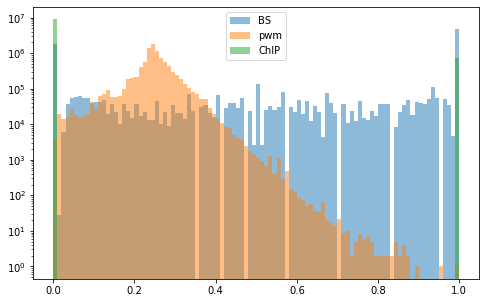

In [22]:
ss=data.groupby(['TF','gene']).agg({'pwm':'min',"W1":'min',"ChIPTF":'max'})
ss.pwm=(ss.pwm-ss.pwm.min())/(ss.pwm.max()-ss.pwm.min())

fpr, tpr, thresholds = metrics.roc_curve(ss.ChIPTF, 1-(ss.W1/100))
roc_auc=metrics.auc(fpr, tpr)

fpr2, tpr2, thresholds2 = metrics.roc_curve(ss.ChIPTF, ss.pwm)
roc_auc2=metrics.auc(fpr2, tpr2)

print(['min pwm motif='+str(roc_auc2),'min wgbs motif='+str(roc_auc)])

plt.figure(figsize=(8, 5))

ss.W1=np.round(1-(ss.W1/100),decimals=4)
ss.pwm=np.round(ss.pwm,decimals=4)

tmp=plt.hist(ss.W1,bins=100,label='BS',alpha=.5,log=True)
tmp=plt.hist(ss.pwm,bins=100,label='pwm',alpha=.5,log=True)
tmp=plt.hist(ss.ChIPTF,bins=100,label='ChIP',alpha=.5,log=True)

plt.legend(loc="best")
table.append(["0_min",roc_auc2,roc_auc])

In [26]:
ss=ss.reset_index()
ss.TF=ss.TF.str.replace('(', '')
ss.TF=ss.TF.str.replace(')', '')
ss.TF=ss.TF.str.replace(' ', '')
ss.gene=ss.gene.str.replace(' ', '')
ss[['TF','gene','pwm']].to_csv('min_pwm_uniqMotif_BS_Chmax_refseq.txt',header=False,index=False,sep='\t')
ss[['TF','gene','W1']].to_csv('min_wgbs_uniqMotif_BS_Chmax_refseq.txt',header=False,index=False,sep='\t')

In [23]:
table

[['0_mean', 0.6082067034901157, 0.6393551915608513],
 ['0_max', 0.722342834898407, 0.4138085647374004],
 ['0_min', 0.38440475373351285, 0.7463724693730607]]

## C. intersect Motif +/-100bp with WGBS and ChIPSeq

#### WGBS and ChIP can be itersected beforehand

In [ ]:
%% bash
#bash MIMB/slop_mega.sh

cut -f1,2,3,4,5 uniq_mega_BS_Ch0.txt|uniq >mega_motif.txt

../../../../udd/rekrg/Tools/bedtools2/bin/bedtools intersect -wa -wb -a mega_motif.txt -b hg38_tss_coord.txt > mega_motif_refseq.txt

../../../../udd/rekrg/Tools/bedtools2/bin/bedtools slop -i mega_motif_refseq.txt -g ../../../../udd/rekrg/Tools/bedtools2/genomes/human.hg38.genome -r 100 -l 100  > slop_mega_motif_refseq.txt

 # cut -f1,2,4,5,9 slop_mega_motif_refseq.txt |sort -k1,1 -k2,2n| uniq > slop_mega_motif_refseq01.txt

../../../../udd/rekrg/Tools/bedtools2/bin/bedtools intersect -wao -a slop_mega_motif_refseq.txt -b GM12878_BS_Ch01.txt > slop_mega_BS_Ch0.txt

cut -f1,2,3,4,5,9,13,14,15,16 slop_mega_BS_Ch0.txt |sed -e "s/(//" -e "s/)//" > slop_mega_BS_Ch1.txt 

# source /proj/relibs/relib00/conda/bin/activate
# source activate mypy3 ## 
# chmod +x MIMB/take_uniq.py

# python MIMB/take_uniq.py


### the resultant file is highly redundant, and since our intention is to form a motif file, we can collapse replicate information to unique entries by taking the first WGBS value

In [ ]:
import pandas as pd
import numpy as np
import multiprocessing as mp
from functools import partial

chunk_size=1000000
#for i in range(np.round(2167207740/chunk_size).astype('int')):

def take_uniq(i,inputA,outputA):
    data=pd.read_csv(inputA,sep=',',names=['only'],header=None,nrows=chunk_size,skiprows=chunk_size*i)
    data = data.sort_values(by='only')
    first = data.groupby('only').first().reset_index()
    print(i/np.round(2167207740/chunk_size))
    first.to_csv(outputA,sep='\t',index=False,header=False,mode='a')

indices=range(np.round(2167207740/chunk_size).astype('int'))

pool = mp.Pool(20)
res  = pool.map(partial(take_uniq,inputA='slop_mega_BS_Ch1.txt',outputA='slop_uniq_mega_BS_Ch1.txt'),indices)



In [85]:
data=pd.read_csv('~/slop100_Motif_BS_Chmax_refseq.zip',sep='\t',usecols=[3,4,5,7,8],names=['ChIPTF','pwm','TF','W1','gene'])

<ipython-input-86-ea0deba583b6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.ChIPTF[data.ChIPTF!='0']=1


['max pwm motif=0.678194251897243', 'max wgbs motif=0.43712826246000336']


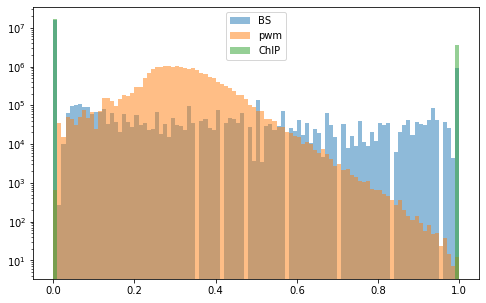

In [86]:
data.ChIPTF[data.ChIPTF!='0']=1
data['ChIPTF']=pd.to_numeric(data['ChIPTF'])
ss=data.groupby(['TF','gene']).agg({'pwm':'max',"W1":'max',"ChIPTF":'max'})
ss.pwm=(ss.pwm-ss.pwm.min())/(ss.pwm.max()-ss.pwm.min())
fpr, tpr, thresholds = metrics.roc_curve(ss.ChIPTF, 1-(ss.W1/100))
roc_auc=metrics.auc(fpr, tpr)

fpr2, tpr2, thresholds2 = metrics.roc_curve(ss.ChIPTF, ss.pwm)
roc_auc2=metrics.auc(fpr2, tpr2)

print(['max pwm motif='+str(roc_auc2),'max wgbs motif='+str(roc_auc)])

plt.figure(figsize=(8, 5))

ss.W1=np.round(1-(ss.W1/100),decimals=4)
ss.pwm=np.round(ss.pwm,decimals=4)

tmp=plt.hist(ss.W1,bins=100,label='BS',alpha=.5,log=True)
tmp=plt.hist(ss.pwm,bins=100,label='pwm',alpha=.5,log=True)
tmp=plt.hist(ss.ChIPTF,bins=100,label='ChIP',alpha=.5,log=True)

plt.legend(loc="best")
table.append(["slop_max",roc_auc2,roc_auc])

In [26]:
ss=ss.reset_index()
ss.TF=ss.TF.str.replace('(', '')
ss.TF=ss.TF.str.replace(')', '')
ss.TF=ss.TF.str.replace(' ', '')
ss.gene=ss.gene.str.replace(' ', '')
ss[['TF','gene','pwm']].to_csv('slop100_max_pwm_uniqMotif_BS_Chmax_refseq.txt',header=False,index=False,sep='\t')
ss[['TF','gene','W1']].to_csv('slop100_max_wgbs_uniqMotif_BS_Chmax_refseq.txt',header=False,index=False,sep='\t')

['mean pwm motif=0.5952283123608906', 'mean wgbs motif=0.6527995861446834']


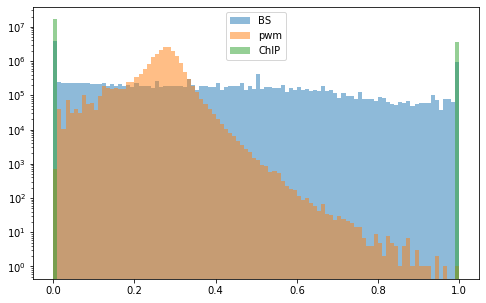

In [87]:
ss=data.groupby(['TF','gene']).agg({'pwm':'mean',"W1":'mean',"ChIPTF":'max'})
ss.pwm=(ss.pwm-ss.pwm.min())/(ss.pwm.max()-ss.pwm.min())
fpr, tpr, thresholds = metrics.roc_curve(ss.ChIPTF, 1-(ss.W1/100))
roc_auc=metrics.auc(fpr, tpr)

fpr2, tpr2, thresholds2 = metrics.roc_curve(ss.ChIPTF, ss.pwm)
roc_auc2=metrics.auc(fpr2, tpr2)

print(['mean pwm motif='+str(roc_auc2),'mean wgbs motif='+str(roc_auc)])

plt.figure(figsize=(8, 5))

ss.W1=np.round(1-(ss.W1/100),decimals=4)
ss.pwm=np.round(ss.pwm,decimals=4)

tmp=plt.hist(ss.W1,bins=100,label='BS',alpha=.5,log=True)
tmp=plt.hist(ss.pwm,bins=100,label='pwm',alpha=.5,log=True)
tmp=plt.hist(ss.ChIPTF,bins=100,label='ChIP',alpha=.5,log=True)

plt.legend(loc="best")
table.append(["slop_mean",roc_auc2,roc_auc])

In [24]:
ss=ss.reset_index()
ss.TF=ss.TF.str.replace('(', '')
ss.TF=ss.TF.str.replace(')', '')
ss.TF=ss.TF.str.replace(' ', '')
ss.gene=ss.gene.str.replace(' ', '')
ss[['TF','gene','pwm']].to_csv('slop100_mean_pwm_uniqMotif_BS_Chmax_refseq.txt',header=False,index=False,sep='\t')
ss[['TF','gene','W1']].to_csv('slop100_mean_wgbs_uniqMotif_BS_Chmax_refseq.txt',header=False,index=False,sep='\t')

['min pwm motif=0.4488681878837647', 'min wgbs motif=0.7509026552761896']


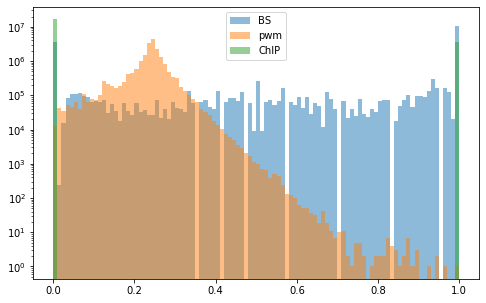

In [88]:
ss=data.groupby(['TF','gene']).agg({'pwm':'min',"W1":'min',"ChIPTF":'max'})
ss.pwm=(ss.pwm-ss.pwm.min())/(ss.pwm.max()-ss.pwm.min())

fpr, tpr, thresholds = metrics.roc_curve(ss.ChIPTF, 1-(ss.W1/100))
roc_auc=metrics.auc(fpr, tpr)

fpr2, tpr2, thresholds2 = metrics.roc_curve(ss.ChIPTF, ss.pwm)
roc_auc2=metrics.auc(fpr2, tpr2)

print(['min pwm motif='+str(roc_auc2),'min wgbs motif='+str(roc_auc)])

plt.figure(figsize=(8, 5))

ss.W1=np.round(1-(ss.W1/100),decimals=4)
ss.pwm=np.round(ss.pwm,decimals=4)

tmp=plt.hist(ss.W1,bins=100,label='BS',alpha=.5,log=True)
tmp=plt.hist(ss.pwm,bins=100,label='pwm',alpha=.5,log=True)
tmp=plt.hist(ss.ChIPTF,bins=100,label='ChIP',alpha=.5,log=True)

plt.legend(loc="best")
table.append(["slop_min",roc_auc2,roc_auc])

In [89]:
ss=ss.reset_index()
ss.TF=ss.TF.str.replace('(', '')
ss.TF=ss.TF.str.replace(')', '')
ss.TF=ss.TF.str.replace(' ', '')
ss.gene=ss.gene.str.replace(' ', '')
ss[['TF','gene','pwm']].to_csv('slop100_min_pwm_uniqMotif_BS_Chmax_refseq.txt',header=False,index=False,sep='\t')
ss[['TF','gene','W1']].to_csv('slop100_min_wgbs_uniqMotif_BS_Chmax_refseq.txt',header=False,index=False,sep='\t')

# III. Summary

We are able to supplement methylation data to the generic motif. However, intersection operations between the limited scales of WGBS when compared to that of the full genome breadth of the motif return a partial motif. Nevertheless this performs well, but only for certain TF-gene links. Rather than further relaxing the window around the motif when intersecting with WGBS as in section II C., we can use what PWM values we would otherwise swap out for WGBS ratios, thus forming a patchwork motif file composed of pwm values and methylation where possible.

# IV. full scale, partial methyl Motif

supplement complete Motif with available methylation and so form a patchwork of values for the PANDA motif backbone.

Rather than ommiting motif regions without methylation data, you instead supplement in PWM information, you can increase the AUROC

In [82]:
data=pd.read_csv('../Downloads/su_mega_BS_Ch0.txt',sep='\t',header=None,nrows=20000000,skiprows=0,names=['chr','start','end','PWM','TF','gene','depth','W1','ChIPTF'])
data.PWM=(data.PWM-data.PWM.min())/(data.PWM.max()-data.PWM.min())
data.ChIPTF=data.ChIPTF.replace('.',0)
data.ChIPTF[data.ChIPTF!=0]=1

data1=data[data.W1=='.']
data2=data[data.W1!='.']
data2.W1 = pd.to_numeric(data2.W1, 'coerce')

# data2.ChIPTF = pd.to_numeric(data2.ChIPTF, 'coerce')

data1.W1=data1.W1.replace('.',np.NaN)
data1.W1=data1.W1.fillna(data.PWM)

data2.W1=1-(np.divide(data2.W1,100))
data=data1.append(data2)

<ipython-input-82-fcb46005ea93>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.ChIPTF[data.ChIPTF!=0]=1


['mean pwm motif=0.5882196725633309', 'mean wgbs motif=0.6455700227055471']


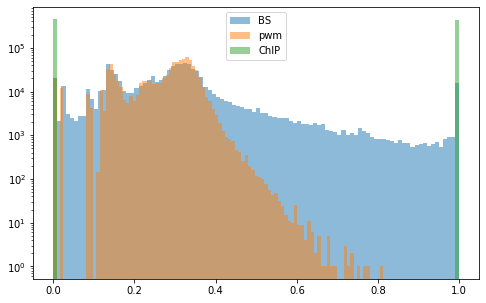

In [76]:
ss=data.groupby(['TF','gene']).agg({'PWM':'mean',"W1":'mean',"ChIPTF":'max'})

fpr, tpr, thresholds = metrics.roc_curve(ss.ChIPTF, ss.W1)
roc_auc=metrics.auc(fpr, tpr)

fpr2, tpr2, thresholds2 = metrics.roc_curve(ss.ChIPTF, ss.PWM)
roc_auc2=metrics.auc(fpr2, tpr2)~!

print(['mean pwm motif='+str(roc_auc2),'mean wgbs motif='+str(roc_auc)])

plt.figure(figsize=(8, 5))

tmp=plt.hist(ss.W1,bins=100,label='BS',alpha=.5,log=True)
tmp=plt.hist(ss.PWM,bins=100,label='pwm',alpha=.5,log=True)
tmp=plt.hist(ss.ChIPTF,bins=100,label='ChIP',alpha=.5,log=True)

plt.legend(loc="best")
# table.append(["slop_mean",roc_auc2,roc_auc])

In [97]:
jeff=np.sum(data.PWM!=data.W1)/data.shape[0]
print(['methyl supplement is '+str(jeff)+'% of entire Motif, increasing AUROC by '+str(np.abs(np.round(roc_auc2-roc_auc,4)))])

['methyl supplement is 0.25119725% of entire Motif, increasing AUROC by 0.0574']
